In [1]:
#Import all the Dependencies
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
#Set all the Constants
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Import data into tensorflow dataset object
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 2152 files belonging to 4 classes.


In [5]:
class_names = dataset.class_names
class_names

['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'potatos.h51']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)


(32, 256, 256, 3)


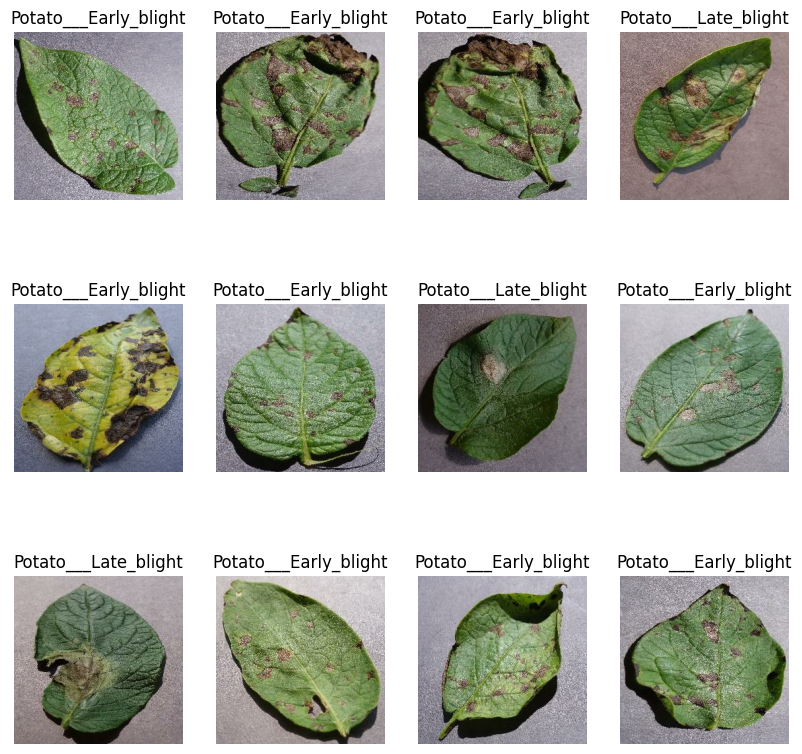

In [7]:
#Visualize some of the images from our dataset
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

Function to Split Dataset

In [8]:
len(dataset)

68

In [9]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [10]:
train_ds = dataset.take(54)
len(train_ds)

54

In [11]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [12]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [13]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [14]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

54

In [18]:
len(val_ds)

6

In [19]:
len(test_ds)

8

In [20]:
#Cache, Shuffle, and Prefetch the Dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Building the Model

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
#Data Augumentation
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
#Applying Data Augmentation to Train Dataset
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

Model Architecture

In [24]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

Compiling the Model

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 500s 4s/step - loss: 0.9212 - accuracy: 0.4688 - val_loss: 0.8912 - val_accuracy: 0.4896
Epoch 2/50
54/54 [==============================] - 219s 4s/step - loss: 0.7647 - accuracy: 0.6672 - val_loss: 0.5551 - val_accuracy: 0.7760
Epoch 3/50
54/54 [==============================] - 210s 4s/step - loss: 0.4618 - accuracy: 0.8206 - val_loss: 0.4159 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 203s 4s/step - loss: 0.3315 - accuracy: 0.8709 - val_loss: 0.3252 - val_accuracy: 0.8542
Epoch 5/50
54/54 [==============================] - 207s 4s/step - loss: 0.2988 - accuracy: 0.8837 - val_loss: 0.3109 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 216s 4s/step - loss: 0.2360 - accuracy: 0.9091 - val_loss: 0.2933 - val_accuracy: 0.8698
Epoch 7/50
54/54 [==============================] - 206s 4s/step - loss: 0.1607 - accuracy: 0.9404 - val_loss: 0.2031 - val_accuracy: 0.9271
Epoch 8/50
54

In [27]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 19s 1s/step - loss: 0.0242 - accuracy: 0.9961


In [28]:
scores

[0.02416491135954857, 0.99609375]

Plotting the Accuracy and Loss Curves

In [29]:
history.params
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [30]:
type(history.history['loss'])
len(history.history['loss'])

50

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.9211752414703369,
 0.7647349238395691,
 0.4617570638656616,
 0.3314985930919647,
 0.2987741231918335]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

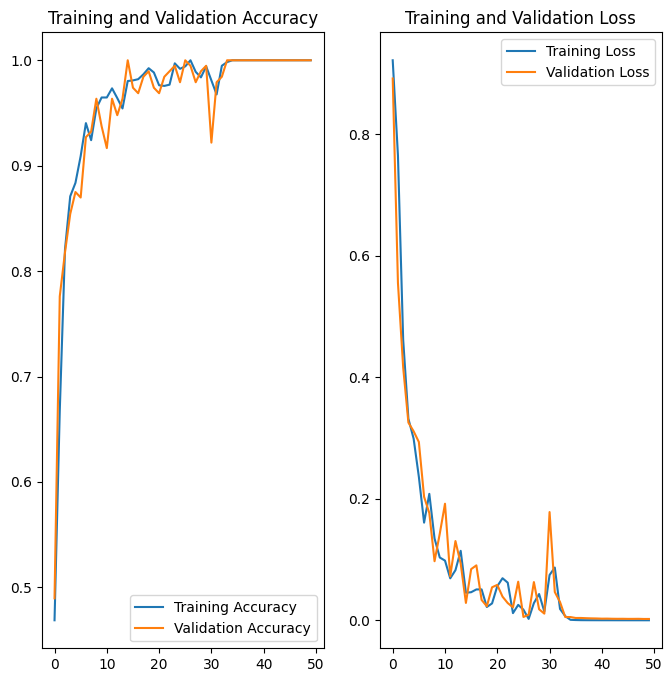

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Potato___Late_blight
1/1 [==============================] - 2s 2s/step
predicted label: Potato___Late_blight


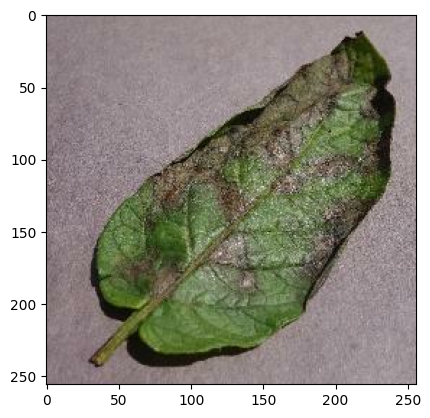

In [34]:
#Run prediction on a sample image
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
#Write a function for inference
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 77ms/step


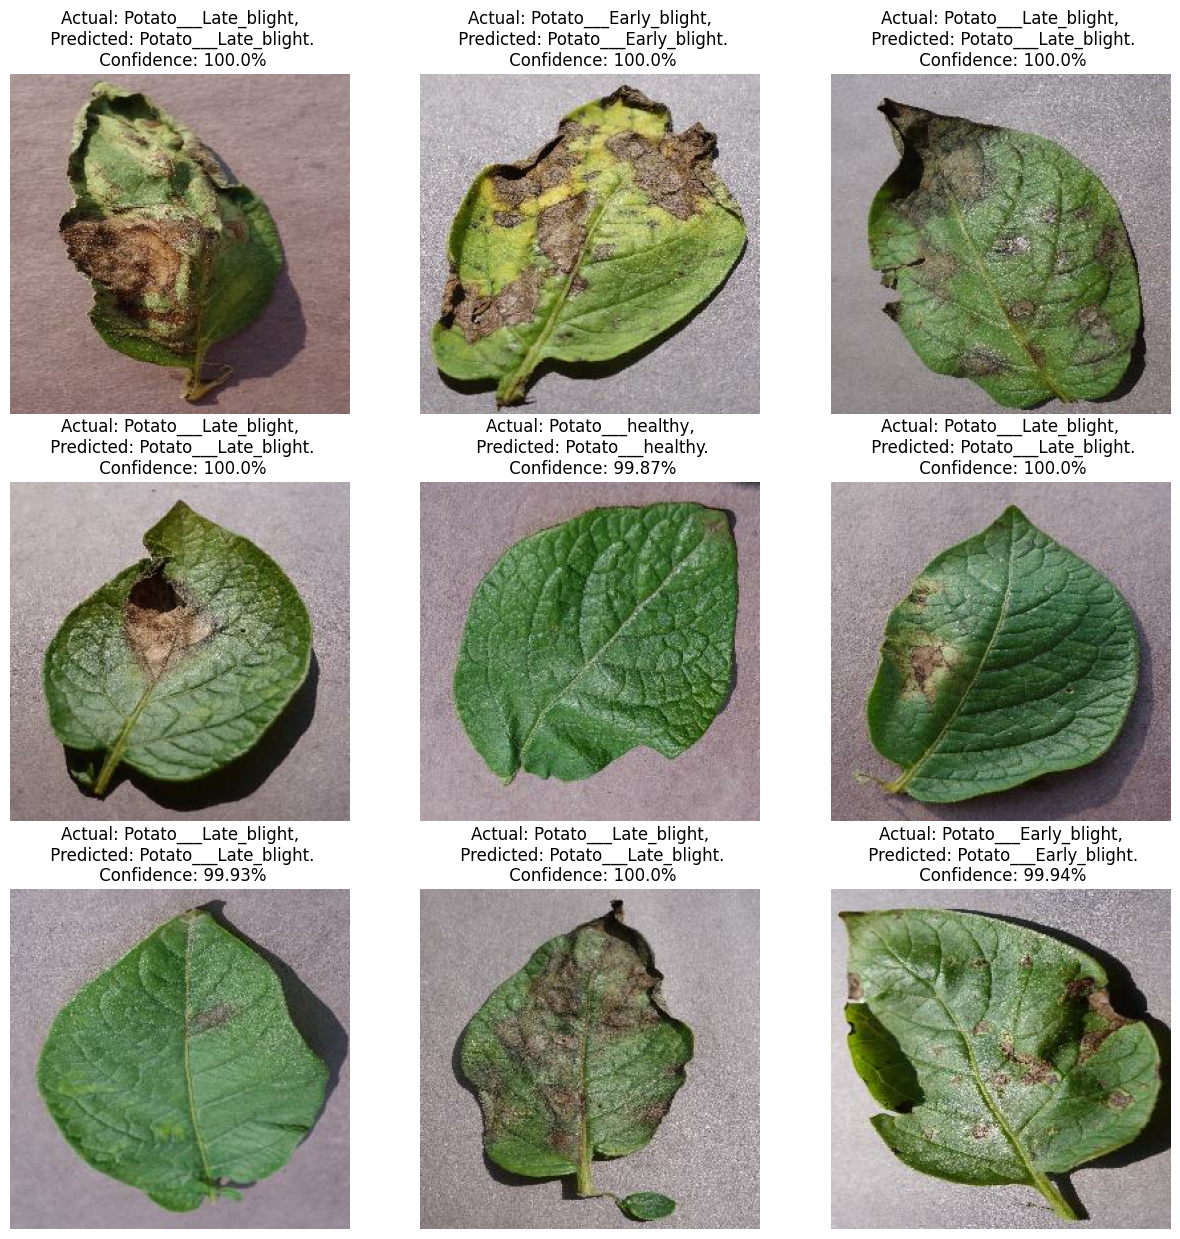

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

Saving the Model

In [43]:
import os

# List all files with the desired extension
files = [i for i in os.listdir("/content/drive/MyDrive/PlantVillage") if i.endswith(".h5")]

# Extract version numbers from filenames
versions = [int(file.split(".h5")[0][-2:]) for file in files]

# Find the maximum version number
if versions:
    model_version = max(versions) + 1
else:
    model_version = 1

# Save the model with the incremented version number
model.save(f"/content/drive/MyDrive/PlantVillage/potatos.h5{model_version}")


In [71]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained CNN model
model = load_model('/content/drive/MyDrive/PlantVillage/potatos.h51')

# Function to preprocess user input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((256, 256))  # Resize image to match model input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Function to make predictions
def predict_disease(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    classes = ['Early Blight', 'Late Blight', 'Healthy Leaves']  # Class labels
    predicted_class = classes[np.argmax(prediction)]
    confidence = prediction[0][np.argmax(prediction)]
    return predicted_class, confidence

# User input image path
user_input_image_path = '/content/drive/MyDrive/leaf1ea.jpeg'  # Change 'user_input_image.jpg' to your input image path

# Predict disease
predicted_class, confidence = predict_disease(user_input_image_path)
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 [==============================] - 0s 235ms/step
Predicted Class: Early Blight
Confidence: 0.99999976


In [73]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained CNN model
model = load_model('/content/drive/MyDrive/PlantVillage/potatos.h51')

# Function to preprocess user input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Convert image to RGB mode
    img = img.resize((256, 256))  # Resize image to match model input size
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

# Function to make predictions
def predict_disease(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    classes = ['Early Blight', 'Late Blight', 'Healthy Leaves']  # Class labels
    predicted_class = classes[np.argmax(prediction)]
    confidence = prediction[0][np.argmax(prediction)]
    return predicted_class, confidence

# User input image path
user_input_image_path = '/content/drive/MyDrive/leaf1ea.jpeg'  # Change 'user_input_image.jpg' to your input image path

# Predict disease
predicted_class, confidence = predict_disease(user_input_image_path)
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 [==============================] - 0s 144ms/step
Predicted Class: Early Blight
Confidence: 0.99999976


In [81]:
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Load the pre-trained CNN model
model = load_model('/content/drive/MyDrive/PlantVillage/potatos.h51')

# Function to preprocess user input image
def preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.convert("RGB")  # Convert image to RGB mode
    img = img.resize((256, 256))  # Resize image to match model input size
    img = image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values to [0, 1]
    img = np.expand_dims(img, axis=0)
    return img

# Function to make predictions
def predict_disease(image_path):
    img = preprocess_image(image_path)
    prediction = model.predict(img)
    classes = ['Early Blight', 'Late Blight', 'Healthy Leaves']  # Class labels
    predicted_class = classes[np.argmax(prediction)]
    confidence = prediction[0][np.argmax(prediction)]
    return predicted_class, confidence

# User input image path
user_input_image_path = '/content/drive/MyDrive/leaf4lb.png'  #jpeg Change 'user_input_image.jpg' to your input image path

# Predict disease
predicted_class, confidence = predict_disease(user_input_image_path)
print("Predicted Class:", predicted_class)
print("Confidence:", confidence)


1/1 [==============================] - 0s 140ms/step
Predicted Class: Late Blight
Confidence: 0.9969945
